In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
# import shap
warnings.filterwarnings('ignore')
import os

In [192]:
sales2022 = pd.read_csv(os.path.join('data','jan_apr_2022.csv'))
sales2023_2024 = pd.read_csv(os.path.join('data','2022_2024.csv'))
item = pd.read_csv(os.path.join('data','item.csv'))
city = pd.read_csv(os.path.join('data','city.csv'))
customer = pd.read_csv(os.path.join('data','customer.csv'))
reward = pd.read_csv(os.path.join('data','reward.csv'))

In [193]:
sales2022['Amount'] = sales2022['Amount'].str.replace(',', '').astype(float)
sales2023_2024['Price after Discount'] = sales2023_2024['Price after Discount'].str.replace(',', '').astype(float)
sales2023_2024['Row Total'] = sales2023_2024['Row Total'].str.replace(',', '').astype(float)
sales2023_2024['Posting Date'] = pd.to_datetime(sales2023_2024['Posting Date'], format='%d-%m-%y')
sales2023_2024['Due Date'] = pd.to_datetime(sales2023_2024['Due Date'], format='%d-%m-%y')

In [194]:
customer['Credit Limit'] = customer['Credit Limit'].str.replace(',', '').astype(float)
customer['Total Return Barang'] = customer['Total Return Barang'].str.replace(',', '').astype(float)
customer['Total Potongan Penjualan'] = customer['Total Potongan Penjualan'].str.replace(',', '').astype(float)

In [195]:
agg_2022 = sales2022.groupby('Customer Code').agg({'Amount':'sum',
                                                   'Invoice No.':'nunique'}).reset_index()

agg_2022 = agg_2022.rename(columns={'Amount':'Amount 2022',
                                    'Invoice No.':'Total Transaction 2022'})
agg_rest = sales2023_2024.groupby('Customer/Vendor Code').agg({'Row Total':'sum',
                                                               'Document Number':'nunique'}).reset_index()

agg_rest = agg_rest.rename(columns={'Customer/Vendor Code':'Customer Code',
                         'Row Total':'Amount 2023',
                         'Document Number':'Total Transaction 2023'})
aggs = pd.merge(agg_rest, agg_2022, on='Customer Code', how='outer')

In [196]:
sum_missing = aggs.isna().sum()
percent_missing = round(aggs.isnull().sum() * 100 / len(aggs),2)
missing_value_df = pd.DataFrame({'column_name': aggs.columns,
                                 'sum_missing': sum_missing,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_df

,column_name,sum_missing,percent_missing
0,Customer Code,0,0.00
1,Amount 2023,71,4.55
2,Total Transaction 2023,71,4.55
3,Amount 2022,1045,66.94
4,Total Transaction 2022,1045,66.94


In [197]:
aggs.fillna(0, inplace=True)
aggs['Total Amount'] = aggs['Amount 2022'] + aggs['Amount 2023']

In [198]:
item_2022 = sales2022[['Customer Code','Item No.']]
item_2023 = sales2023_2024[['Customer/Vendor Code','Item No.']]

item_2023 =item_2023.rename(columns={'Customer/Vendor Code':'Customer Code'})
item_k = item[['Item No.','Kategori','Sub Item']]
item_u = pd.concat([item_2022, item_2023], ignore_index=True)
item_m = pd.merge(item_u, item_k, on='Item No.', how='left')
item_uni = item_m.groupby('Customer Code').agg({'Item No.':'nunique'}).reset_index()

item_uni = item_uni.rename(columns={'Item No.':'Total Unique Item'})

In [199]:
# Group by Customer Code and Kategori, count the occurrences, and find the top category
top_categories = item_m.groupby(['Customer Code', 'Kategori']).size().reset_index(name='kategori_count')
top_categories = top_categories.sort_values(by=['Customer Code', 'kategori_count'], ascending=[True, False])
top_categories = top_categories.groupby('Customer Code').first().reset_index()

In [200]:
top_cate = top_categories[['Customer Code','Kategori','kategori_count']]

top_cate =top_cate.rename(columns={'Kategori':'Top Category'})

In [201]:
item_all = pd.merge(item_uni, top_cate, on='Customer Code', how='left')
item_all = item_all[~(item_all['Top Category'].isna())]

In [202]:
aggs['Total Transaction'] = aggs['Total Transaction 2022'] + aggs['Total Transaction 2023']
aggs_n = aggs[['Customer Code','Total Amount','Total Transaction']]
aggs_all = pd.merge(aggs_n, item_all, on= 'Customer Code', how='left')
aggs_all[aggs_all['Top Category'].isna()]

aggs_all = aggs_all.rename(columns={'Customer Code':'BP Code'})

In [203]:
customer_add = pd.merge(customer, aggs_all, on='BP Code', how='inner')

In [204]:
sales2022['Invoice Date'] = pd.to_datetime(sales2022['Invoice Date'])

# Group transactions by customer and find first and last sales dates
first_last_sales_dates = sales2022.groupby('Customer Code')['Invoice Date'].agg(['min', 'max']).reset_index()

# Rename the columns
first_last_sales_dates.rename(columns={'min': 'First Sales Date 2022', 'max': 'Last Sales Date 2022'}, inplace=True)

In [205]:
sales2023_2024['Posting Date'] = pd.to_datetime(sales2023_2024['Posting Date'])

# Group transactions by customer and find first and last sales dates
first_last_sales_dates_1 = sales2023_2024.groupby('Customer/Vendor Code')['Posting Date'].agg(['min', 'max']).reset_index()

# Rename the columns
first_last_sales_dates_1.rename(columns={'min': 'First Sales Date 2023/24', 'max': 'Last Sales Date 2023/24',
                                         'Customer/Vendor Code':'Customer Code'}, inplace=True)

In [206]:
first_last_dates = pd.merge(first_last_sales_dates_1,first_last_sales_dates, on='Customer Code', how='outer')

In [207]:
first_last_dates['First Sales Date'] = first_last_dates[['First Sales Date 2023/24', 'First Sales Date 2022']].min(axis=1)
first_last_dates['Last Sales Date'] = first_last_dates[['Last Sales Date 2023/24', 'Last Sales Date 2022']].max(axis=1)



In [208]:
# Drop unnecessary columns
first_last_dates.drop(['First Sales Date 2023/24', 'Last Sales Date 2023/24', 'First Sales Date 2022', 'Last Sales Date 2022'], axis=1, inplace=True)

In [209]:
first_last_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Customer Code     1561 non-null   object        
 1   First Sales Date  1561 non-null   datetime64[ns]
 2   Last Sales Date   1561 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 36.7+ KB


In [210]:
first_last_dates.rename(columns={'Customer Code':'BP Code'}, inplace=True)

In [211]:
customer_add = pd.merge(customer_add, first_last_dates, on='BP Code', how='left')

In [212]:
customer_add

,BP Code,BP Name,Shipping Type,Group Code,BP Type,Active,Payment Terms Code,Price List No.,Credit Limit,Sales Employee Code,...,Total Return Barang,Potongan Penjualan,Total Potongan Penjualan,Total Amount,Total Transaction,Total Unique Item,Top Category,kategori_count,First Sales Date,Last Sales Date
0,ACH-00001,INDRA (ACEH),KSI,C0,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Shifa Anggraeni,...,0.0,0,0.0,26743500.0,6.0,71.0,AKSESORIES CAMPUR,23.0,2022-01-22,2022-06-02
1,ACH-00002,NUSA INDAH,LARIS CARGO,C2,Customer,Yes,14 Days,Harga Jual - Lusin,30000000.0,Opik Hidayat,...,51000.0,0,0.0,300811175.0,97.0,724.0,TAS & DOMPET,258.0,2022-01-24,2024-03-02
2,ACH-00003,ZAZIRA,WIRA AGUNG,C4,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Shifa Anggraeni,...,330000.0,0,0.0,81977262.0,16.0,290.0,AKSESORIES CAMPUR,115.0,2022-02-19,2024-01-05
3,ACH-00004,TOKO BINTANG PERMATA,KSI,C,Customer,Yes,14 Days,Harga Jual - Lusin,20000000.0,Saepudin,...,0.0,0,0.0,71799000.0,35.0,250.0,TAS & DOMPET,153.0,2022-01-22,2024-03-12
4,ACH-00005,IQBAL,KSI,C8,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Dina,...,0.0,0,0.0,109386000.0,23.0,147.0,TAS & DOMPET,75.0,2022-02-28,2024-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,K03-00018,JKT ACONG,KURIR TOKO,K03,Customer,No,0 Days,Harga Jual - Lusin,0.0,Sania,...,0.0,0,0.0,2083500.0,2.0,2.0,AKSESORIES CAMPUR,2.0,2022-09-03,2022-11-03
1524,K03-00033,TOKO SUCI ACC,IPN CARGO,K03,Customer,No,7 Days,Harga Jual - Lusin,0.0,Sania,...,0.0,0,0.0,39127000.0,4.0,37.0,AKSESORIES CAMPUR,13.0,2022-01-13,2022-11-01
1525,K03-00035,TOKO GIO,PANORAMA,K03,Customer,No,7 Days,Harga Jual - Lusin,0.0,Sania,...,0.0,0,0.0,2175000.0,1.0,1.0,ALAT MAKE UP,1.0,2022-02-22,2022-02-22
1526,K03-00038,TOKO FITA ACC,IPN CARGO,K03,Customer,No,0 Days,Harga Jual - Lusin,0.0,Sania,...,0.0,0,0.0,0.0,5.0,26.0,AKSESORIS RAMBUT,32.0,2022-01-27,2022-04-14


customer_add sudah dibuat

In [213]:
customer_add.head()

,BP Code,BP Name,Shipping Type,Group Code,BP Type,Active,Payment Terms Code,Price List No.,Credit Limit,Sales Employee Code,...,Total Return Barang,Potongan Penjualan,Total Potongan Penjualan,Total Amount,Total Transaction,Total Unique Item,Top Category,kategori_count,First Sales Date,Last Sales Date
0,ACH-00001,INDRA (ACEH),KSI,C0,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Shifa Anggraeni,...,0.0,0,0.0,26743500.0,6.0,71.0,AKSESORIES CAMPUR,23.0,2022-01-22,2022-06-02
1,ACH-00002,NUSA INDAH,LARIS CARGO,C2,Customer,Yes,14 Days,Harga Jual - Lusin,30000000.0,Opik Hidayat,...,51000.0,0,0.0,300811175.0,97.0,724.0,TAS & DOMPET,258.0,2022-01-24,2024-03-02
2,ACH-00003,ZAZIRA,WIRA AGUNG,C4,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Shifa Anggraeni,...,330000.0,0,0.0,81977262.0,16.0,290.0,AKSESORIES CAMPUR,115.0,2022-02-19,2024-01-05
3,ACH-00004,TOKO BINTANG PERMATA,KSI,C,Customer,Yes,14 Days,Harga Jual - Lusin,20000000.0,Saepudin,...,0.0,0,0.0,71799000.0,35.0,250.0,TAS & DOMPET,153.0,2022-01-22,2024-03-12
4,ACH-00005,IQBAL,KSI,C8,Customer,Yes,0 Days,Harga Jual - Lusin,0.0,Dina,...,0.0,0,0.0,109386000.0,23.0,147.0,TAS & DOMPET,75.0,2022-02-28,2024-02-20


In [214]:
sales2022.rename(columns={'Invoice Date':'date'}, inplace=True)
sales2023_2024.rename(columns={'Posting Date':'date','Customer/Vendor Code':'Customer Code','Row Total':'Amount'}, inplace=True)


In [215]:
#full_sales = pd.merge(sales2022,sales2023_2024,on='Customer Code',how='left')
full_sales = pd.concat([sales2022,sales2023_2024],axis=0)

In [216]:
full_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715101 entries, 0 to 642595
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Invoice No.               72505 non-null   object        
 1   date                      715101 non-null  datetime64[ns]
 2   Quantity                  715101 non-null  float64       
 3   Unit                      714510 non-null  object        
 4   Amount                    715101 non-null  float64       
 5   Item Description          72505 non-null   object        
 6   Item No.                  714723 non-null  object        
 7   Customer Code             715097 non-null  object        
 8   Customer Name             72505 non-null   object        
 9   Canceled                  642596 non-null  object        
 10  Sales Employee Name       642596 non-null  object        
 11  Document Number           642596 non-null  float64       
 12  Due Dat

In [217]:
full_sales.head()

,Invoice No.,date,Quantity,Unit,Amount,Item Description,Item No.,Customer Code,Customer Name,Canceled,Sales Employee Name,Document Number,Due Date,Group Name,Customer/Vendor Name,Payment Terms Code,Item/Service Description,Price after Discount
0,38143 - 38144,2022-01-28,12.0,LSN,270000.0,ANTING BOLA 2 DOVE PJG,ATG-242C,SMS-00004,TOKO RUDI,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,44468 - 74,2022-01-21,1.0,PAK,270000.0,ANTING BULAT POLOS KAR 12 PSG (10 KAR),ATG-249A1,JBA-00044,CUCU FARIDAH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,38143 - 38144,2022-01-28,12.0,LSN,840000.0,ANTING DAUN MATA JURAI,ATG-235B,SMS-00004,TOKO RUDI,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,39599 - 39600,2022-01-29,3.0,LSN,165000.0,ANTING JURAI BULAT KRISTAL MATA,ATG-247E,SMU-00011,SANNY,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,40519 - 40536,2022-01-22,3.0,LSN,165000.0,ANTING JURAI KUPU2 KRISTAL MATA,ATG-247D,JBA-00044,CUCU FARIDAH,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [218]:
full_sales['date'] = pd.to_datetime(full_sales['date'], format='%d-%m-%y')

In [219]:
full_sales['year'] = full_sales['date'].dt.year
full_sales['month'] = full_sales['date'].dt.month

In [220]:
full_sales[full_sales['year']==2024].tail()

,Invoice No.,date,Quantity,Unit,Amount,Item Description,Item No.,Customer Code,Customer Name,Canceled,Sales Employee Name,Document Number,Due Date,Group Name,Customer/Vendor Name,Payment Terms Code,Item/Service Description,Price after Discount,year,month
642591,NaN,2024-03-31,1.0,PCS,26100.0,NaN,M-K06A-265P1,JKT-00233,NaN,N,Saepudin,240015211.0,2024-04-30,CONSIGMENT,RAMBLA,30 Days,KAMINO K06A-265P1 JEPIT SALON PLASTIK MARBEL B...,26100.0,2024,3
642592,NaN,2024-03-31,3.0,PCS,17400.0,NaN,M-K06B-181B,JKT-00233,NaN,N,Saepudin,240015211.0,2024-04-30,CONSIGMENT,RAMBLA,30 Days,KAMINO K06B-181B KARET JEPANG TPU MIKA MTF,5800.0,2024,3
642593,NaN,2024-03-31,1.0,PCS,8700.0,NaN,M-K06G-321D1,JKT-00233,NaN,N,Saepudin,240015211.0,2024-04-30,CONSIGMENT,RAMBLA,30 Days,KAMINO K06G-321D1 JEPIT SALON PVC 4.5CM KTK BL...,8700.0,2024,3
642594,NaN,2024-03-31,1.0,PCS,23200.0,NaN,M-K06H-326F2,JKT-00233,NaN,N,Saepudin,240015211.0,2024-04-30,CONSIGMENT,RAMBLA,30 Days,KAMINO K06H-326F2 JEPIT SALON CAMPUR SILANG LI...,23200.0,2024,3
642595,NaN,2024-03-30,60.0,PAK,1440000.0,NaN,KSK-2535H3,JBA-00163,NaN,N,Ika Sofiyatun,240015243.0,2024-03-30,C,NAYYA GALERI (AYU LESTARI),0 Days,KAOS KAKI POUCH ANAK MTF BUNGA W (10 PSG),24000.0,2024,3


In [221]:
customer_per_month_2022 = full_sales[full_sales['year']==2022].groupby('month')['Customer Code'].nunique()
customer_per_month_2022.rename('Customer Count 2022',inplace=True)

month
1     313
2     339
3     364
4     323
5     329
6     391
7     356
8     485
9     506
10    498
11    553
12    516
Name: Customer Count 2022, dtype: int64

In [222]:
customer_per_month_2023 = full_sales[full_sales['year']==2023].groupby('month')['Customer Code'].nunique()
customer_per_month_2023.rename('Customer Count 2023',inplace=True)
customer_per_month_2024 = full_sales[full_sales['year']==2024].groupby('month')['Customer Code'].nunique()
customer_per_month_2024.rename('Customer Count 2024',inplace=True)
customer_per_month = pd.concat([customer_per_month_2022,customer_per_month_2023,customer_per_month_2024],axis=1)

In [223]:
customer_per_month.head()

,Customer Count 2022,Customer Count 2023,Customer Count 2024
month,,,
1,313,474,661.0
2,339,441,697.0
3,364,479,667.0
4,323,410,NaN
5,329,515,NaN


In [224]:
customer_per_month1 = pd.concat([customer_per_month['Customer Count 2022'],customer_per_month['Customer Count 2023'],customer_per_month['Customer Count 2024']],axis=1)

<Axes: xlabel='month'>

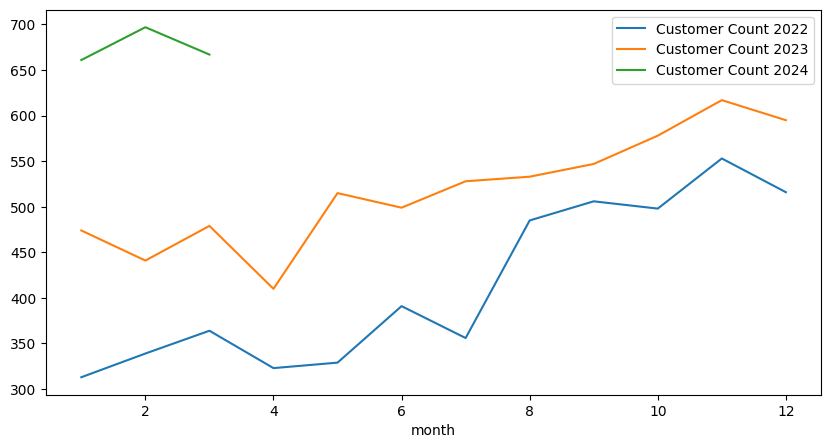

In [225]:
customer_per_month1.plot(kind='line',figsize=(10,5))

Menelusuri seasonality per tahun 

In [226]:
customer_per_jan = full_sales[full_sales['month']==1].groupby('year')['Customer Code'].nunique()
customer_per_jan.rename('Customer Count January',inplace=True)

year
2022    313
2023    474
2024    661
Name: Customer Count January, dtype: int64

In [227]:
customer_per_feb = full_sales[full_sales['month']==2].groupby('year')['Customer Code'].nunique()
customer_per_feb.rename('Customer Count February',inplace=True)

year
2022    339
2023    441
2024    697
Name: Customer Count February, dtype: int64

In [228]:
customer_per_mar = full_sales[full_sales['month']==3].groupby('year')['Customer Code'].nunique()
customer_per_mar.rename('Customer Count March',inplace=True)

year
2022    364
2023    479
2024    667
Name: Customer Count March, dtype: int64

In [229]:
customer_per_apr = full_sales[full_sales['month']==4].groupby('year')['Customer Code'].nunique()
customer_per_apr.rename('Customer Count April',inplace=True)

year
2022    323
2023    410
Name: Customer Count April, dtype: int64

In [230]:
customer_per_may = full_sales[full_sales['month']==5].groupby('year')['Customer Code'].nunique()
customer_per_may.rename('Customer Count May',inplace=True)

year
2022    329
2023    515
Name: Customer Count May, dtype: int64

In [231]:
customer_per_jun = full_sales[full_sales['month']==6].groupby('year')['Customer Code'].nunique()
customer_per_jun.rename('Customer Count June',inplace=True)

year
2022    391
2023    499
Name: Customer Count June, dtype: int64

In [232]:
customer_per_jul = full_sales[full_sales['month']==7].groupby('year')['Customer Code'].nunique()
customer_per_jul.rename('Customer Count July',inplace=True)

year
2022    356
2023    528
Name: Customer Count July, dtype: int64

In [233]:
customer_per_aug = full_sales[full_sales['month']==8].groupby('year')['Customer Code'].nunique()
customer_per_aug.rename('Customer Count August',inplace=True)

year
2022    485
2023    533
Name: Customer Count August, dtype: int64

In [234]:
customer_per_sep = full_sales[full_sales['month']==9].groupby('year')['Customer Code'].nunique()
customer_per_sep.rename('Customer Count September',inplace=True)    

year
2022    506
2023    547
Name: Customer Count September, dtype: int64

In [235]:
customer_per_oct = full_sales[full_sales['month']==10].groupby('year')['Customer Code'].nunique()   
customer_per_oct.rename('Customer Count October',inplace=True)

year
2022    498
2023    578
Name: Customer Count October, dtype: int64

In [236]:
customer_per_nov = full_sales[full_sales['month']==11].groupby('year')['Customer Code'].nunique()
customer_per_nov.rename('Customer Count November',inplace=True)

year
2022    553
2023    617
Name: Customer Count November, dtype: int64

In [237]:
customer_per_dec = full_sales[full_sales['month']==12].groupby('year')['Customer Code'].nunique()
customer_per_dec.rename('Customer Count December',inplace=True)

year
2022    516
2023    595
Name: Customer Count December, dtype: int64

In [238]:
customer_per_month = pd.concat([customer_per_jan,customer_per_feb,customer_per_mar,customer_per_apr,customer_per_may,customer_per_jun,customer_per_jul,customer_per_aug,customer_per_sep,customer_per_oct,customer_per_nov,customer_per_dec],axis=1)

In [239]:
customer_per_month.head()

,Customer Count January,Customer Count February,Customer Count March,Customer Count April,Customer Count May,Customer Count June,Customer Count July,Customer Count August,Customer Count September,Customer Count October,Customer Count November,Customer Count December
year,,,,,,,,,,,,
2022,313,339,364,323.0,329.0,391.0,356.0,485.0,506.0,498.0,553.0,516.0
2023,474,441,479,410.0,515.0,499.0,528.0,533.0,547.0,578.0,617.0,595.0
2024,661,697,667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


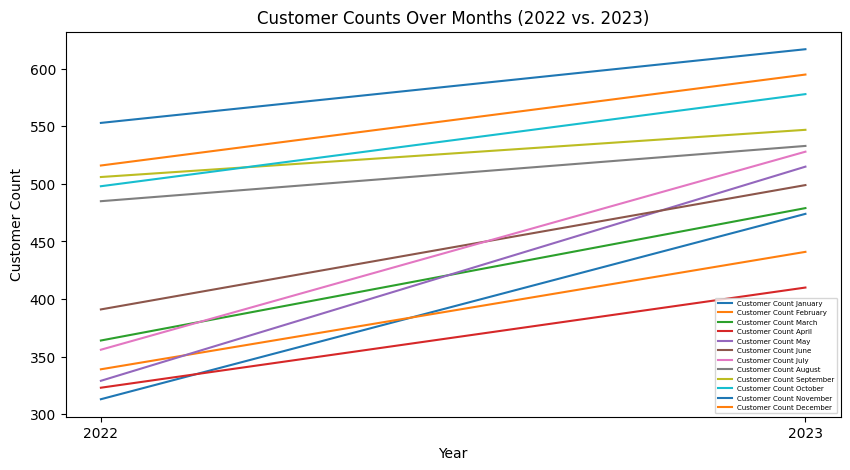

In [240]:
ax = customer_per_month[customer_per_month.index<2024].plot(kind='line',figsize=(10,5))
ax.legend(fontsize=5)
plt.xlabel('Year')
plt.xticks(ticks=[2022,2023],labels=[2022,2023])
plt.ylabel('Customer Count')
plt.title('Customer Counts Over Months (2022 vs. 2023)')
plt.show()

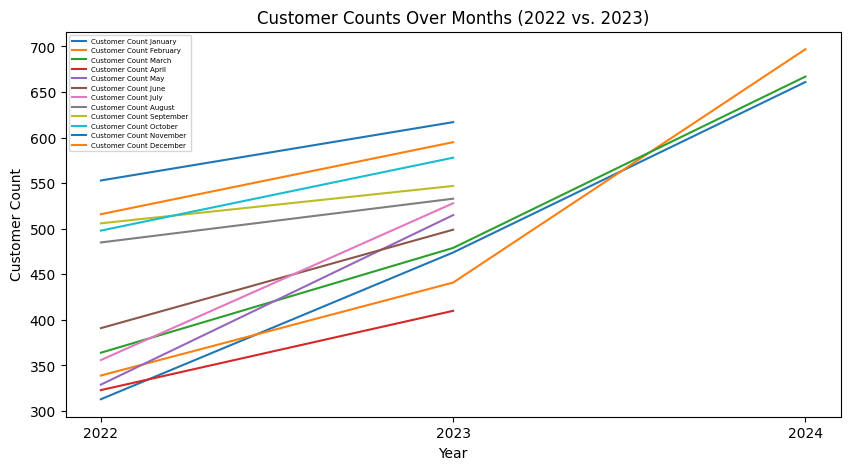

In [241]:
ax = customer_per_month.plot(kind='line',figsize=(10,5))
ax.legend(fontsize=5)
plt.xlabel('Year')
plt.xticks(ticks=[2022,2023,2024],labels=[2022,2023,2024])
plt.ylabel('Customer Count')
plt.title('Customer Counts Over Months')
plt.show()

Total Transaksi

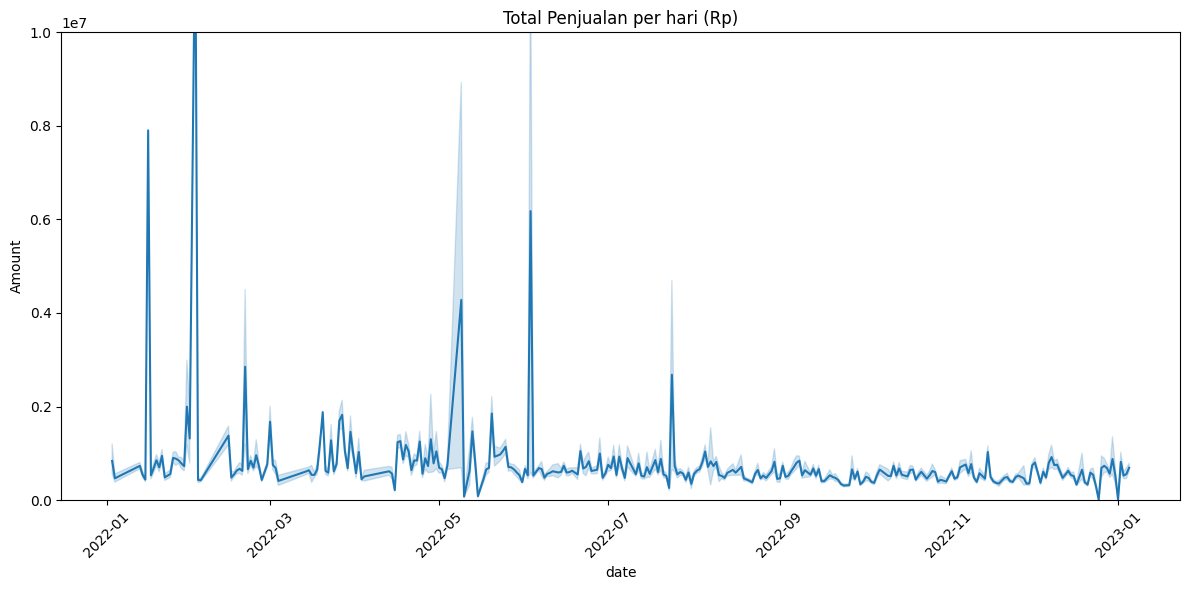

In [246]:
plt.figure(figsize=(12,6))
sns.lineplot(data=full_sales[full_sales['date']<'01-06-2023'], x='date', y='Amount')
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.title('Total Penjualan per hari (Rp)')
plt.ylim(0, 10000000)
plt.tight_layout()

In [251]:
customer_add.columns

Index(['BP Code', 'BP Name', 'Shipping Type', 'Group Code', 'BP Type',
       'Active', 'Payment Terms Code', 'Price List No.', 'Credit Limit',
       'Sales Employee Code', 'Creation Date', 'Churn', 'Return Barang',
       'Total Return Barang', 'Potongan Penjualan', 'Total Potongan Penjualan',
       'Total Amount', 'Total Transaction', 'Total Unique Item',
       'Top Category', 'kategori_count', 'First Sales Date',
       'Last Sales Date'],
      dtype='object')

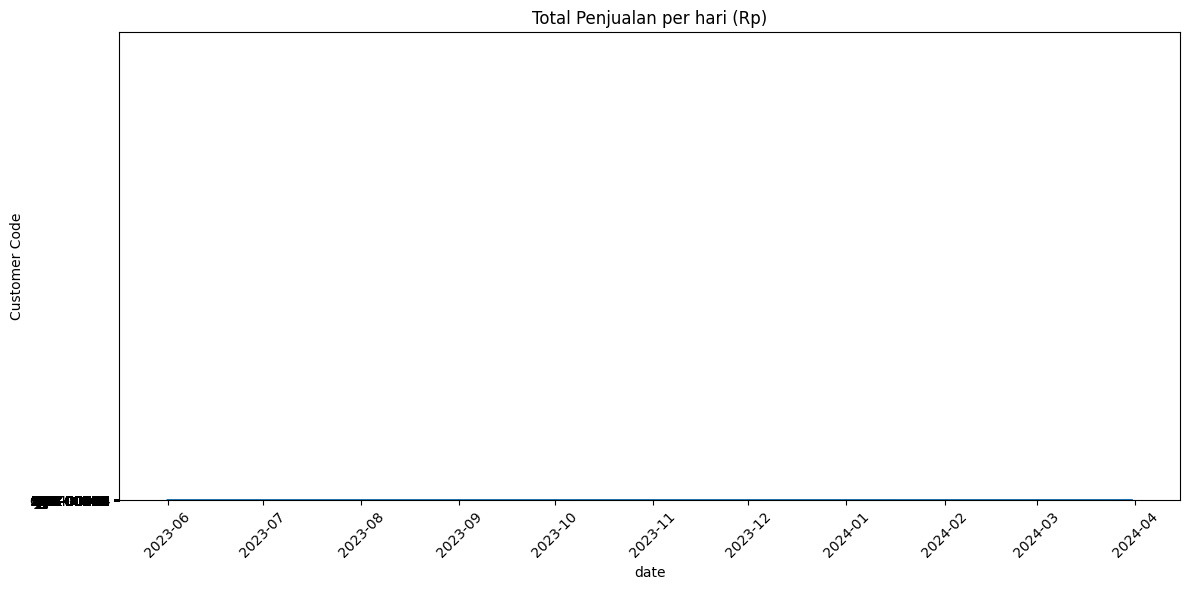

In [249]:
plt.figure(figsize=(12,6))
sns.lineplot(data=full_sales[full_sales['date']>'31-05-2023'], x='date', y='Customer Code')
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.title('Total Penjualan per hari (Rp)')
plt.ylim(0, 10000000)
plt.tight_layout()

In [248]:
plt.figure(figsize=(12,6))
sns.lineplot(data=full_sales[full_sales['date']<'01-06-2023'], x='date', y='Total Transaction')
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.title('Total Penjualan per hari (Rp)')
plt.ylim(0, 10000000)
plt.tight_layout()

ValueError: Could not interpret value `Total Transaction` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

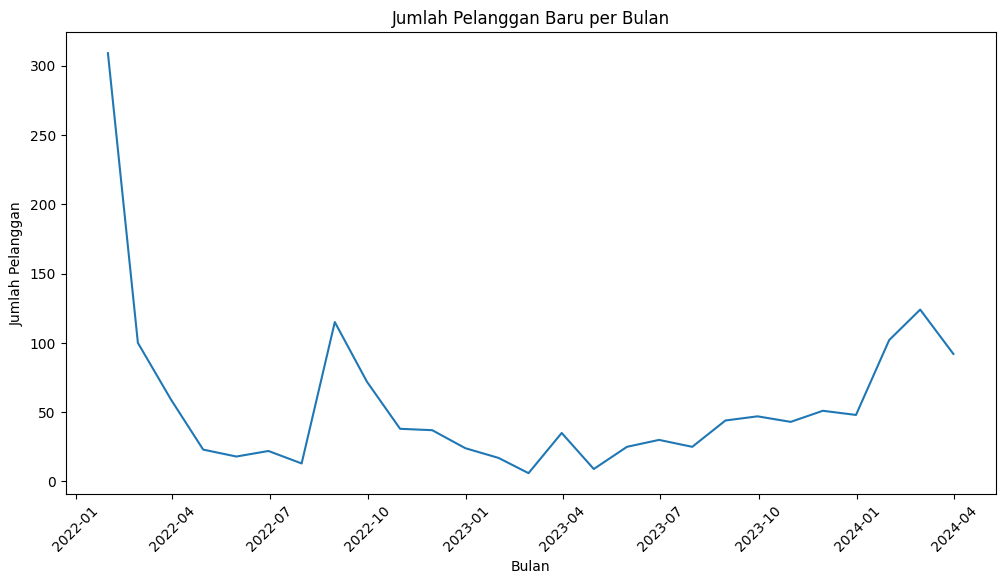

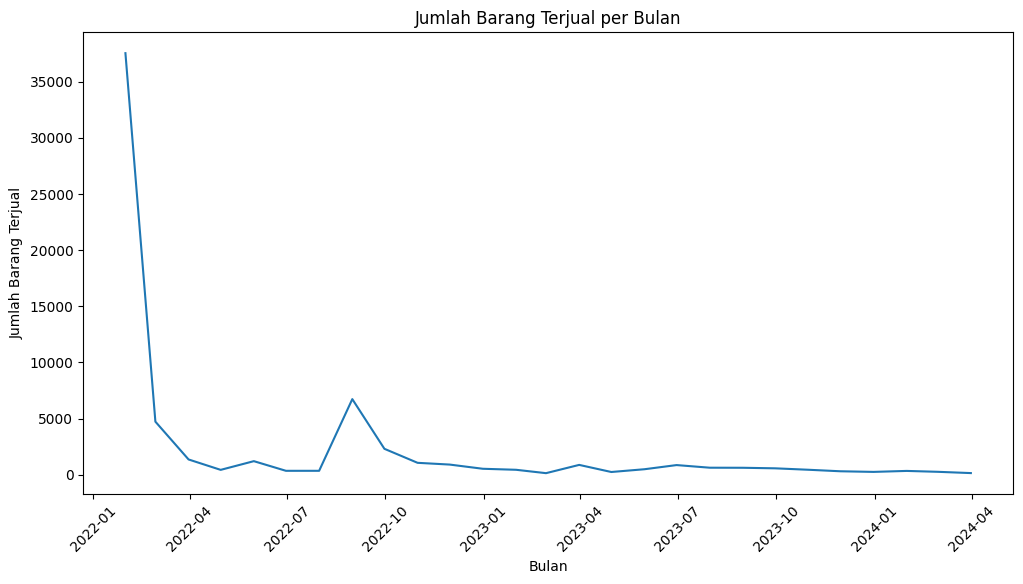

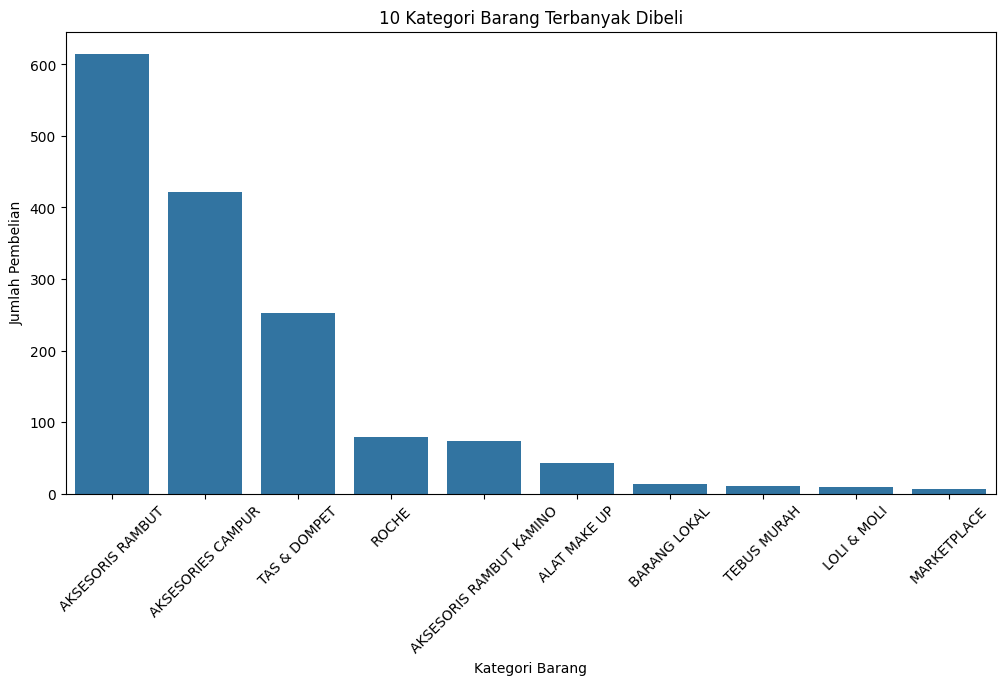

In [244]:
# EDA: Menampilkan jumlah pelanggan setiap bulan
customer_add['First Sales Date'] = pd.to_datetime(customer_add['First Sales Date'])
customer_per_month = customer_add.groupby(pd.Grouper(key='First Sales Date', freq='M')).size().reset_index()
customer_per_month.columns = ['First Sales Date', 'Total Customers']
plt.figure(figsize=(12, 6))
sns.lineplot(data=customer_per_month, x='First Sales Date', y='Total Customers')
plt.title('Jumlah Pelanggan Baru per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.show()

# EDA: Menampilkan jumlah barang terjual setiap bulan
sales_per_month = customer_add.groupby(pd.Grouper(key='First Sales Date', freq='M'))['Total Transaction'].sum().reset_index()
sales_per_month.columns = ['First Sales Date', 'Total Transaction']
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_per_month, x='First Sales Date', y='Total Transaction')
plt.title('Jumlah Barang Terjual per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Barang Terjual')
plt.xticks(rotation=45)
plt.show()

# Analisis kategori barang terbanyak dibeli
top_categories = customer_add['Top Category'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('10 Kategori Barang Terbanyak Dibeli')
plt.xlabel('Kategori Barang')
plt.ylabel('Jumlah Pembelian')
plt.xticks(rotation=45)
plt.show()